In [309]:
import json
import pandas as pd
from collections import defaultdict
from typing import List, Dict, Tuple

# Load the JSON files
with open('..\data\structured\ELSST_eval_set_label.json', 'r') as file:
    golden_data = json.load(file)

# Assume original_data.json and predicted_data.json are also provided
with open('..\data\structured\elsst_label.json', 'r') as file:
    original_data = json.load(file)

with open('..\outputs\elsst_gpt-3.5-turbo-instruct_with_background.json', 'r') as file:
    predicted_data = json.load(file)


### Building Ancestor/Descendants Data from Full Dataset

In [310]:

# Function to build ancestor and descendant maps using prefLabel
def build_ancestor_descendant_maps(data: List[Dict]):
    ancestors = defaultdict(set)
    descendants = defaultdict(set)

    def add_ancestors(term, parent):
        """Recursive function to add parent and all transitive broader terms."""
        ancestors[term].add(parent)
        for grandparent in ancestors[parent]:
            ancestors[term].add(grandparent)
            
    def add_descendants(parent, term):
        """Recursive function to add term and all transitive narrower terms."""
        descendants[parent].add(term)
        for child in descendants[term]:
            descendants[parent].add(child)
    
    # Populate the ancestor and descendant maps
    for term in data:
        term_label = term['label']
        for rel in term['relationships']:
            if rel['predicate'] == 'broader':
                add_ancestors(term_label, rel['target'])
                add_descendants(rel['target'], term_label)
            elif rel['predicate'] == 'narrower':
                add_descendants(term_label, rel['target'])
                add_ancestors(rel['target'], term_label)
    
    # Ensure full transitivity for all terms
    for term in data:
        term_label = term['label']
        for ancestor in list(ancestors[term_label]):
            add_ancestors(term_label, ancestor)
        for descendant in list(descendants[term_label]):
            add_descendants(term_label, descendant)
    
    return ancestors, descendants

ancestor_map, descendant_map = build_ancestor_descendant_maps(original_data)

In [311]:

# Assuming full_ontology, golden_data, and predicted_data are already loaded
def extract_relationships(data):
    relationships = {}
    for item in data:
        if 'label' not in item:
            continue
        term_label = item['label']
        rels = {}
        if 'relationships' in item and item['relationships'] is not None and isinstance(item['relationships'], Iterable):
            for rel in item['relationships']:
                predicate = rel['predicate']
                target = rel['target']
                if predicate not in rels:
                    rels[predicate] = []
                rels[predicate].append(target)
            relationships[term_label] = rels
    return relationships

golden_rels = extract_relationships(golden_data)
predicted_rels = extract_relationships(predicted_data)


In [312]:
# Helper functions to get ancestors and descendants
def get_all_ancestors(term, ancestor_map):
    return ancestor_map[term]

def get_all_descendants(term, descendant_map):
    return descendant_map[term]


### Calculate for Each Combination of Term-Predicate-Target Separately

total generated terms: 789
hierarchically_correct: 10
tp: 55
fp: 734
fn: 691
Accuracy: 0.037162162162162164
Precision: 0.0697084917617237
Recall: 0.07372654155495978
F1 Score: 0.07166123778501629


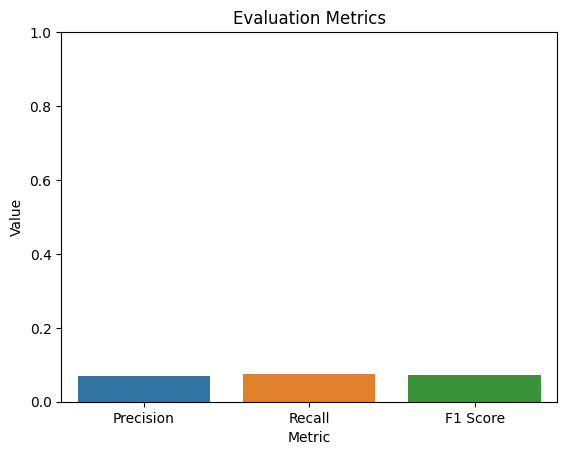

In [266]:
from collections import defaultdict
from typing import Dict, List, Set

true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0
true_positives_list = []
true_negatives_list = []
false_positives_list = []
false_negatives_list = []
total_generated_terms = 0
hierarchically_correct = 0



def get_all_ancestors(term, ancestor_map):
    return ancestor_map.get(term, set())

def get_all_descendants(term, descendant_map):
    return descendant_map.get(term, set())

# Revised scoring function
def score_rels_with_hierarchy(expected: Dict[str, List[str]], predicted: Dict[str, List[str]], ancestor_map: Dict[str, set], descendant_map: Dict[str, set], term_label: str, strict=True):

    global hierarchically_correct, total_generated_terms, true_positives, true_positives_list, false_positives, false_positives_list, false_negatives, false_negatives_list

    # print(f"The label for which we calculated the terms is: {term_label}")
    # print(f"The generated rels are: {predicted}")
    # print(f"The golden rels are: {expected}")

    all_preds = set(expected.keys()).union(predicted.keys())

    for pred in all_preds:
        # print(f"The predicate is: {pred}")
        expected_tgts = expected.get(pred, [])
        predicted_tgts = predicted.get(pred, [])

        expected_tgts = [tgt.upper().strip() for tgt in expected_tgts]
        predicted_tgts = [tgt.upper().strip() for tgt in predicted_tgts]

        # True Positives and False Positives - Correct!
        for predicted_tgt in predicted_tgts:
            total_generated_terms += 1
            # print(f"The predicted rel is: {predicted_tgt}")
            if predicted_tgt in expected_tgts:
                true_positives += 1
                # outcome.tp += 1
            else:
                if pred.lower().strip() == 'broader':
                    matched = False
                    # getting ancestors of initial term label
                    # if predicted relationship matches ancestor then fn+=0.5
                    for ancestor in get_all_ancestors(term_label, ancestor_map):
                        if ancestor == predicted_tgt:
                            hierarchically_correct += 1
                            matched = True
                            if strict:
                                false_positives += 1
                                false_positives_list.append(f"{term_label}_{pred}_{predicted_tgt}")
                            else:
                                false_positives += 0.5
                                false_positives_list.append(f"{term_label}_{pred}_{predicted_tgt}")
                            break
                    if not matched and f"{term_label}_{pred}_{predicted_tgt}" not in false_positives_list:
                        false_positives += 1
                        false_positives_list.append(f"{term_label}_{pred}_{predicted_tgt}")
                elif pred.lower().strip() == 'narrower':
                    matched = False
                    for descendant in get_all_descendants(term_label, descendant_map):
                        if descendant == predicted_tgt:
                            hierarchically_correct += 1
                            matched = True
                            if strict:
                                false_positives += 1
                                false_positives_list.append(f"{term_label}_{pred}_{predicted_tgt}")
                            else:
                                false_positives += 0.5
                                false_positives_list.append(f"{term_label}_{pred}_{predicted_tgt}")
                            break
                    if not matched and f"{term_label}_{pred}_{predicted_tgt}" not in false_positives_list:
                        false_positives += 1
                        false_positives_list.append(f"{term_label}_{pred}_{predicted_tgt}")
                else:
                    false_positives += 1
                    false_positives_list.append(f"{term_label}_{pred}_{predicted_tgt}")

        # False Negatives
        for expected_tgt in expected_tgts:
            if expected_tgt not in predicted_tgts and f"{term_label}_{pred}_{expected_tgt}" not in false_negatives_list:
                
                # print("Here we have a case of false negative")
                # print("Expected target:", expected_tgt, "is not in:")
                # print("Predicted targets:", predicted_tgts)
                # print("-----")
                
                false_negatives += 1
                false_negatives_list.append(f"{term_label}_{pred}_{expected_tgt}")


# Score the hierarchical relationships
# scores = []
for index, (term_label, expected_rels) in enumerate(golden_rels.items()):
    term_label = term_label.upper().strip()
    predicted_rels_for_term = predicted_rels.get(term_label, {})
    score_rels_with_hierarchy(expected_rels, predicted_rels_for_term, ancestor_map, descendant_map, term_label)
    # scores.append(score.__dict__)
    # if index == 20: break

print("total generated terms:", total_generated_terms)
print("hierarchically_correct:", hierarchically_correct)
print("tp:",true_positives)
print("fp:",false_positives)
print("fn:",false_negatives)

accuracy = (true_positives + true_negatives) / (true_positives + false_positives + false_negatives + true_negatives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)


# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

# Optionally, visualize results using matplotlib or seaborn if required
import matplotlib.pyplot as plt
import seaborn as sns

# Example visualization: Precision, Recall, and F1 Score
metrics = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Value': [precision, recall, f1_score]
})

sns.barplot(x='Metric', y='Value', data=metrics)
plt.ylim(0, 1)
plt.title('Evaluation Metrics')
plt.show()


### Calculate For Each Class Specifically (Related, Narrower, Broader)

In [313]:
from collections import defaultdict
from typing import Dict, List, Set

true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0
true_positives_list = []
true_negatives_list = []
false_positives_list = []
false_negatives_list = []
total_generated_terms = 0
hierarchically_correct = 0


related_tp = 0
related_fp = 0
related_fn = 0

narrower_tp = 0
narrower_fp = 0
narrower_fn = 0

broader_tp = 0
broader_fp = 0
broader_fn = 0


def get_all_ancestors(term, ancestor_map):
    return ancestor_map.get(term, set())

def get_all_descendants(term, descendant_map):
    return descendant_map.get(term, set())

# Revised scoring function
def score_rels_with_hierarchy(expected: Dict[str, List[str]], predicted: Dict[str, List[str]], ancestor_map: Dict[str, set], descendant_map: Dict[str, set], term_label: str, strict=False):

    global related_fp, related_fn, related_tp, narrower_tp, narrower_fp, narrower_fn, broader_tp, broader_fp, broader_fn, hierarchically_correct, total_generated_terms, true_positives, true_positives_list, false_positives, false_positives_list, false_negatives, false_negatives_list

    # print(f"The label for which we calculated the terms is: {term_label}")
    # print(f"The generated rels are: {predicted}")
    # print(f"The golden rels are: {expected}")

    all_preds = set(expected.keys()).union(predicted.keys())

    for pred in all_preds:
        # print(f"The predicate is: {pred}")
        expected_tgts = expected.get(pred, [])
        predicted_tgts = predicted.get(pred, [])

        expected_tgts = [tgt.upper().strip() for tgt in expected_tgts]
        predicted_tgts = [tgt.upper().strip() for tgt in predicted_tgts]

        # True Positives and False Positives - Correct!
        for predicted_tgt in predicted_tgts:
            total_generated_terms += 1
            # print(f"The predicted rel is: {predicted_tgt}")
            if predicted_tgt in expected_tgts:
                if pred.lower().strip() == 'related':
                    related_tp += 1
                elif pred.lower().strip() == 'narrower':
                    narrower_tp += 1
                elif pred.lower().strip() == 'broader':
                    broader_tp += 1
                true_positives += 1
                # outcome.tp += 1
            else:
                if pred.lower().strip() == 'broader':
                    matched = False
                    # getting ancestors of initial term label
                    # if predicted relationship matches ancestor then fn+=0.5
                    for ancestor in get_all_ancestors(term_label, ancestor_map):
                        if ancestor == predicted_tgt:
                            hierarchically_correct += 1
                            matched = True
                            if strict:
                                broader_fp += 1
                                false_positives += 1
                                false_positives_list.append(f"{term_label}_{pred}_{predicted_tgt}")
                            else:
                                broader_fp += 0.5
                                false_positives += 0.5
                                false_positives_list.append(f"{term_label}_{pred}_{predicted_tgt}")
                            break
                    if not matched and f"{term_label}_{pred}_{predicted_tgt}" not in false_positives_list:
                        broader_fp += 1
                        false_positives += 1
                        false_positives_list.append(f"{term_label}_{pred}_{predicted_tgt}")
                elif pred.lower().strip() == 'narrower':
                    matched = False
                    for descendant in get_all_descendants(term_label, descendant_map):
                        if descendant == predicted_tgt:
                            hierarchically_correct += 1
                            matched = True
                            if strict:
                                narrower_fp += 1
                                false_positives += 1
                                false_positives_list.append(f"{term_label}_{pred}_{predicted_tgt}")
                            else:
                                narrower_fp += 0.5
                                false_positives += 0.5
                                false_positives_list.append(f"{term_label}_{pred}_{predicted_tgt}")
                            break
                    if not matched and f"{term_label}_{pred}_{predicted_tgt}" not in false_positives_list:
                        narrower_fp += 1
                        false_positives += 1
                        false_positives_list.append(f"{term_label}_{pred}_{predicted_tgt}")
                else:
                    related_fp += 1
                    false_positives += 1
                    false_positives_list.append(f"{term_label}_{pred}_{predicted_tgt}")

        # False Negatives
        for expected_tgt in expected_tgts:
            if expected_tgt not in predicted_tgts and f"{term_label}_{pred}_{expected_tgt}" not in false_negatives_list:
                
                if pred.lower().strip() == 'related':
                    related_fn += 1
                elif pred.lower().strip() == 'broader':
                    broader_fn += 1
                elif pred.lower().strip() == 'narrower':
                    narrower_fn += 1
                # print("Here we have a case of false negative")
                # print("Expected target:", expected_tgt, "is not in:")
                # print("Predicted targets:", predicted_tgts)
                # print("-----")
                
                false_negatives += 1
                false_negatives_list.append(f"{term_label}_{pred}_{expected_tgt}")


# Score the hierarchical relationships
# scores = []
for index, (term_label, expected_rels) in enumerate(golden_rels.items()):
    term_label = term_label.upper().strip()
    predicted_rels_for_term = predicted_rels.get(term_label, {})
    score_rels_with_hierarchy(expected_rels, predicted_rels_for_term, ancestor_map, descendant_map, term_label)
    # scores.append(score.__dict__)
    # if index == 20: break


for pred in ['related', 'narrower', 'broader']:
    print(f"For predicate: {pred}")

    if pred == 'related':
        print(f'tp:', related_tp)
        print(f'fp:', related_fp)
        print(f'fn:', related_fn)
        precision = related_tp / (related_tp + related_fp)
        recall = related_tp / (related_tp + related_fn)
        f1 = 2* (precision * recall) / (precision + recall)
        print(f'recall:', recall)
        print(f'precision:', precision)
        print(f'f1:', f1)
    elif pred == 'broader':
        print(f'tp:', broader_tp)
        print(f'fp:', broader_fp)
        print(f'fn:', broader_fn)
        precision = broader_tp / (broader_tp + broader_fp)
        recall = broader_tp / (broader_tp + broader_fn)
        f1 = 2* (precision * recall) / (precision + recall)
        print(f'recall:', recall)
        print(f'precision:', precision)
        print(f'f1:', f1)
    elif pred == 'narrower':
        print(f'tp:', narrower_tp)
        print(f'fp:', narrower_fp)
        print(f'fn:', narrower_fn)
        precision = narrower_tp / (narrower_tp + narrower_fp)
        recall = narrower_tp / (narrower_tp + narrower_fn)
        f1 = 2* (precision * recall) / (precision + recall)
        print(f'recall:', recall)
        print(f'precision:', precision)
        print(f'f1:', f1)


For predicate: related
tp: 27
fp: 406
fn: 271
recall: 0.09060402684563758
precision: 0.06235565819861432
f1: 0.07387140902872777
For predicate: narrower
tp: 5
fp: 65.5
fn: 235
recall: 0.020833333333333332
precision: 0.07092198581560284
f1: 0.0322061191626409
For predicate: broader
tp: 27
fp: 132.0
fn: 165
recall: 0.140625
precision: 0.16981132075471697
f1: 0.15384615384615385
